In [ ]:
# folder = 'flowgan_marin_adv'
# for i in range(81,100,5):
#     !python main.py --dataset 'mnist' --img_size 28 --no_of_layers 5 --batch_size 32 --netG './mnist_adv_flowgan_marin/netG_epoch_{i}.pth' --generate 1 --generate_sample_dir $folder --generate_num_imgs 1000
#     !python -m pytorch_fid '/nfs/students/winter-term-2020/project-5/project-5-manna/flow_gan/mnistdata/mnist_png/training/' './Generated_Images/flowgan_marin_adv'
#     !rm -rf ./Generated_Images/$folder

In [ ]:
# folders = ['mnist_adv_flowgan_marin','mnist_hybrid_ckpt','mnist_mle_ckpt']
# folders1 = ['mnist_adv_flowgan_marin1','mnist_hybrid_ckpt1','mnist_mle_ckpt1']
# epochs = [100,87,99]
# epochs = [100,87,99]
# for i,folder in enumerate(folders):
#     folder1 = folders1[i]
#     for index in range(0,epochs[i]+1,5):
#         !python main.py --dataset 'mnist' --img_size 28 --no_of_layers 5 --batch_size 32 --netG './$folder/netG_epoch_{index}.pth' --generate 1 --generate_sample_dir $folder1 --generate_num_imgs 10000
#         !python -m pytorch_fid '/nfs/students/winter-term-2020/project-5/project-5-manna/flow_gan/mnistdata/mnist_png/training/' './Generated_Images/{folder1}' >>  ./FID_scores/$folder1'.txt'
#         !rm -rf ./Generated_Images/$folder1

In [ ]:
# folder = 'mm'
# !echo $folder'.txt'
# !pwd

In [ ]:

# for i in range(1,4,1):
#     !python hello.py >> mm.txt

In [ ]:
# folder = 'flowgan_debugging_mle_del'
# !python main.py --dataset 'mnist' --img_size 28 --no_of_layers 5 --batch_size 1 --netG './mnist_adv_flowgan_marin/netG_epoch_66.pth' --generate 1 --generate_sample_dir $folder --generate_num_imgs 1000
    

In [ ]:
# from numpy import load
# # load dict of arrays
# dict_data = load('data.npz')
# # extract the first array
# data = dict_data['arr_0']
# # print the array
# print(data)



In [ ]:
# import seaborn as sns
# print(sns.__version__)
# sns.distplot(data)

In [ ]:
# data = np.append(data,np.ones(10000))

In [ ]:
# np.ones(10000)

In [ ]:
# from matplotlib import pyplot as plt 
# import numpy as np 




# # Creating histogram 
# fig, ax = plt.subplots(figsize =(10, 7)) 
# ax.hist(data) #bins = [0, 25, 50, 75, 100]) 

# # Show plot 
# plt.show() 


epoch| FID
-----| ----
1 | 199
6 | 93
11| 105
16| 87
21| 93
26| 111
31| 87
36| 98
41| 123
46| 92
51| 100
56| 102
61| 81
66| 35
71| 92
76| 117
81| 79
86| 83
91| 72
96| 78



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

try:
    from torchvision.models.utils import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url

# Inception weights ported to Pytorch from
# http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz
FID_WEIGHTS_URL = 'https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth'  # noqa: E501


class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=(DEFAULT_BLOCK_INDEX,),
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False,
                 use_fid_inception=True):
        """Build pretrained InceptionV3

        Parameters
        ----------
        output_blocks : list of int
            Indices of blocks to return features of. Possible values are:
                - 0: corresponds to output of first max pooling
                - 1: corresponds to output of second max pooling
                - 2: corresponds to output which is fed to aux classifier
                - 3: corresponds to output of final average pooling
        resize_input : bool
            If true, bilinearly resizes input to width and height 299 before
            feeding input to model. As the network without fully connected
            layers is fully convolutional, it should be able to handle inputs
            of arbitrary size, so resizing might not be strictly needed
        normalize_input : bool
            If true, scales the input from range (0, 1) to the range the
            pretrained Inception network expects, namely (-1, 1)
        requires_grad : bool
            If true, parameters of the model require gradients. Possibly useful
            for finetuning the network
        use_fid_inception : bool
            If true, uses the pretrained Inception model used in Tensorflow's
            FID implementation. If false, uses the pretrained Inception model
            available in torchvision. The FID Inception model has different
            weights and a slightly different structure from torchvision's
            Inception model. If you want to compute FID scores, you are
            strongly advised to set this parameter to true to get comparable
            results.
        """
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        if use_fid_inception:
            inception = fid_inception_v3()
        else:
            inception = _inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps

        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)

        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp


def _inception_v3(*args, **kwargs):
    """Wraps `torchvision.models.inception_v3`

    Skips default weight inititialization if supported by torchvision version.
    See https://github.com/mseitzer/pytorch-fid/issues/28.
    """
    try:
        version = tuple(map(int, torchvision.__version__.split('.')[:2]))
    except ValueError:
        # Just a caution against weird version strings
        version = (0,)

    if version >= (0, 6):
        kwargs['init_weights'] = False

    return torchvision.models.inception_v3(*args, **kwargs)


def fid_inception_v3():
    """Build pretrained Inception model for FID computation

    The Inception model for FID computation uses a different set of weights
    and has a slightly different structure than torchvision's Inception.

    This method first constructs torchvision's Inception and then patches the
    necessary parts that are different in the FID Inception model.
    """
    inception = _inception_v3(num_classes=1008,
                              aux_logits=False,
                              pretrained=False)
    inception.Mixed_5b = FIDInceptionA(192, pool_features=32)
    inception.Mixed_5c = FIDInceptionA(256, pool_features=64)
    inception.Mixed_5d = FIDInceptionA(288, pool_features=64)
    inception.Mixed_6b = FIDInceptionC(768, channels_7x7=128)
    inception.Mixed_6c = FIDInceptionC(768, channels_7x7=160)
    inception.Mixed_6d = FIDInceptionC(768, channels_7x7=160)
    inception.Mixed_6e = FIDInceptionC(768, channels_7x7=192)
    inception.Mixed_7b = FIDInceptionE_1(1280)
    inception.Mixed_7c = FIDInceptionE_2(2048)

    state_dict = load_state_dict_from_url(FID_WEIGHTS_URL, progress=True)
    inception.load_state_dict(state_dict)
    return inception


class FIDInceptionA(torchvision.models.inception.InceptionA):
    """InceptionA block patched for FID computation"""
    def __init__(self, in_channels, pool_features):
        super(FIDInceptionA, self).__init__(in_channels, pool_features)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        # Patch: Tensorflow's average pool does not use the padded zero's in
        # its average calculation
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1,
                                   count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionC(torchvision.models.inception.InceptionC):
    """InceptionC block patched for FID computation"""
    def __init__(self, in_channels, channels_7x7):
        super(FIDInceptionC, self).__init__(in_channels, channels_7x7)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch7x7 = self.branch7x7_1(x)
        branch7x7 = self.branch7x7_2(branch7x7)
        branch7x7 = self.branch7x7_3(branch7x7)

        branch7x7dbl = self.branch7x7dbl_1(x)
        branch7x7dbl = self.branch7x7dbl_2(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_3(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_4(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_5(branch7x7dbl)

        # Patch: Tensorflow's average pool does not use the padded zero's in
        # its average calculation
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1,
                                   count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch7x7, branch7x7dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionE_1(torchvision.models.inception.InceptionE):
    """First InceptionE block patched for FID computation"""
    def __init__(self, in_channels):
        super(FIDInceptionE_1, self).__init__(in_channels)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        # Patch: Tensorflow's average pool does not use the padded zero's in
        # its average calculation
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1,
                                   count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionE_2(torchvision.models.inception.InceptionE):
    """Second InceptionE block patched for FID computation"""
    def __init__(self, in_channels):
        super(FIDInceptionE_2, self).__init__(in_channels)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        # Patch: The FID Inception model uses max pooling instead of average
        # pooling. This is likely an error in this specific Inception
        # implementation, as other Inception models use average pooling here
        # (which matches the description in the paper).
        branch_pool = F.max_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)

In [2]:
"""Calculates the Frechet Inception Distance (FID) to evalulate GANs

The FID metric calculates the distance between two distributions of images.
Typically, we have summary statistics (mean & covariance matrix) of one
of these distributions, while the 2nd distribution is given by a GAN.

When run as a stand-alone program, it compares the distribution of
images that are stored as PNG/JPEG at a specified location with a
distribution given by summary statistics (in pickle format).

The FID is calculated by assuming that X_1 and X_2 are the activations of
the pool_3 layer of the inception net for generated samples and real world
samples respectively.

See --help to see further details.

Code apapted from https://github.com/bioinf-jku/TTUR to use PyTorch instead
of Tensorflow

Copyright 2018 Institute of Bioinformatics, JKU Linz

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

   http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""
import os
import pathlib
from argparse import ArgumentDefaultsHelpFormatter, ArgumentParser
from multiprocessing import cpu_count

import numpy as np
import torch
import torchvision.transforms as TF
from PIL import Image
from scipy import linalg
from torch.nn.functional import adaptive_avg_pool2d

try:
    from tqdm import tqdm
except ImportError:
    # If tqdm is not available, provide a mock version of it
    def tqdm(x):
        return x

from pytorch_fid.inception import InceptionV3

parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
parser.add_argument('--batch-size', type=int, default=50,
                    help='Batch size to use')
parser.add_argument('--device', type=str, default=None,
                    help='Device to use. Like cuda, cuda:0 or cpu')
parser.add_argument('--dims', type=int, default=2048,
                    choices=list(InceptionV3.BLOCK_INDEX_BY_DIM),
                    help=('Dimensionality of Inception features to use. '
                          'By default, uses pool3 features'))
parser.add_argument('path', type=str, nargs=2,
                    help=('Paths to the generated images or '
                          'to .npz statistic files'))

IMAGE_EXTENSIONS = {'bmp', 'jpg', 'jpeg', 'pgm', 'png', 'ppm',
                    'tif', 'tiff', 'webp'}


class ImagePathDataset(torch.utils.data.Dataset):
    def __init__(self, files, transforms=None):
        self.files = files
        self.transforms = transforms

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        path = self.files[i]
        img = Image.open(path).convert('RGB')
        if self.transforms is not None:
            img = self.transforms(img)
        return img


def get_activations(files, model, batch_size=50, dims=2048, device='cpu'):
    """Calculates the activations of the pool_3 layer for all images.

    Params:
    -- files       : List of image files paths
    -- model       : Instance of inception model
    -- batch_size  : Batch size of images for the model to process at once.
                     Make sure that the number of samples is a multiple of
                     the batch size, otherwise some samples are ignored. This
                     behavior is retained to match the original FID score
                     implementation.
    -- dims        : Dimensionality of features returned by Inception
    -- device      : Device to run calculations

    Returns:
    -- A numpy array of dimension (num images, dims) that contains the
       activations of the given tensor when feeding inception with the
       query tensor.
    """
    model.eval()

    if batch_size > len(files):
        print(('Warning: batch size is bigger than the data size. '
               'Setting batch size to data size'))
        batch_size = len(files)

    dataset = ImagePathDataset(files, transforms=TF.ToTensor())
    dataloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=batch_size,
                                             shuffle=False,
                                             drop_last=False,
                                             num_workers=cpu_count())

    pred_arr = np.empty((len(files), dims))

    start_idx = 0

    for batch in tqdm(dataloader):
        batch = batch.to(device)

        with torch.no_grad():
            pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
        if pred.size(2) != 1 or pred.size(3) != 1:
            pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

        pred = pred.squeeze(3).squeeze(2).cpu().numpy()

        pred_arr[start_idx:start_idx + pred.shape[0]] = pred

        start_idx = start_idx + pred.shape[0]

    return pred_arr


def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).

    Stable version by Dougal J. Sutherland.

    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.

    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1)
            + np.trace(sigma2) - 2 * tr_covmean)


def calculate_activation_statistics(files, model, batch_size=50, dims=2048,
                                    device='cpu'):
    """Calculation of the statistics used by the FID.
    Params:
    -- files       : List of image files paths
    -- model       : Instance of inception model
    -- batch_size  : The images numpy array is split into batches with
                     batch size batch_size. A reasonable batch size
                     depends on the hardware.
    -- dims        : Dimensionality of features returned by Inception
    -- device      : Device to run calculations

    Returns:
    -- mu    : The mean over samples of the activations of the pool_3 layer of
               the inception model.
    -- sigma : The covariance matrix of the activations of the pool_3 layer of
               the inception model.
    """
    print("batch_size1", batch_size)
    act = get_activations(files, model, batch_size, dims, device)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma


def compute_statistics_of_path(path, model, batch_size, dims, device):
    if path.endswith('.npz'):
        with np.load(path) as f:
            m, s = f['mu'][:], f['sigma'][:]
    else:
        path = pathlib.Path(path)
        files = sorted([file for ext in IMAGE_EXTENSIONS
                       for file in path.glob('*.{}'.format(ext))])
        print("batch_size", batch_size)
        m, s = calculate_activation_statistics(files, model, batch_size,
                                               dims, device)

    return m, s


def calculate_fid_given_paths(paths, batch_size, device, dims,t,m,s):
    """Calculates the FID of two paths"""
    for p in paths:
        if not os.path.exists(p):
            raise RuntimeError('Invalid path: %s' % p)

    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]

    model = InceptionV3([block_idx]).to(device)
    
    if t== 0:
        m1, s1 = compute_statistics_of_path(paths[0], model, batch_size,
                                        dims, device)
    else:
        m1,s1=m,s
    m2, s2 = compute_statistics_of_path(paths[1], model, batch_size,
                                        dims, device)
    fid_value = calculate_frechet_distance(m1, s1, m2, s2)

    return fid_value,m1,s1


def main(path,  t=0, m=0,s=0):
    #args = parser.parse_args()
    dims = 2048
    batch_size = 16
    device = torch.device('cuda' if (torch.cuda.is_available()) else 'cpu')
    print(batch_size)
    fid_value,m1,s1 = calculate_fid_given_paths(path,
                                          batch_size,
                                          device,
                                          dims,t,m,s)
    print('FID: ', fid_value)
    return fid_value,m1,s1



In [ ]:
torch.__version__

In [ ]:
import pickle
folders = ['mnist_adv_flowgan_marin','mnist_hybrid_ckpt','mnist_mle_ckpt']
folders1 = ['mnist_adv_flowgan_marin1','mnist_hybrid_ckpt1','mnist_mle_ckpt1']
epochs = [100,87,99]
epochs = [100,87,99]
d = {}
t=0
m1=0
s1=0
for i,folder in enumerate(folders):
    folder1= folders1[i]
    d[folder1]=[]
    for index in range(0,epochs[i]+1):
        !python main.py --dataset 'mnist' --img_size 28 --no_of_layers 5 --batch_size 32 --netG './$folder/netG_epoch_{index}.pth' --generate 1 --generate_sample_dir $folder1 --generate_num_imgs 1000
        fid,m1,s1 = main(['/nfs/students/winter-term-2020/project-5/mnist_png/training/',f"./Generated_Images/{folder1}"], t,m1,s1)
        d[folder1].append(fid)
        !rm -rf ./Generated_Images/$folder1
        if t%10==0:
            print(d)
            pickle.dump(d, open('FID_cont_result_dict.pkl', 'wb'))
        t=t+1
    pickle.dump(d, open('FID_cont_result_dict.pkl', 'wb'))

In [8]:
import pickle
objectRep = open("FID_cont_result_dict.pkl", "rb")
fid = pickle.load(objectRep)

new = open("new.pkl", "rb")
rest = pickle.load(new)

In [9]:
fid.keys()

dict_keys(['cifar_adv_ckpt1', 'cifar_hybrid_ckpt1', 'cifar_mle_ckpt1'])

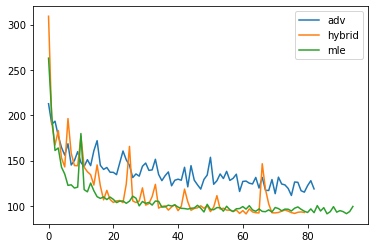

In [10]:
import matplotlib.pyplot as plt

adv_fids = np.array(fid['cifar_adv_ckpt1'])
x = np.arange(len(adv_fids))
plt.plot(x, adv_fids, label='adv')

adv_fids = np.append(np.array(fid['cifar_hybrid_ckpt1']), np.array(rest['cifar_hybrid_ckpt1']))
x = np.arange(len(adv_fids))
plt.plot(x, adv_fids, label='hybrid')

adv_fids = np.array(fid['cifar_mle_ckpt1'])
x = np.arange(len(adv_fids))
plt.plot(x, adv_fids, label='mle')

plt.legend()
# Display a figure.
plt.show()

Text(0.5, 1.0, 'CIFAR_ADV_Training')

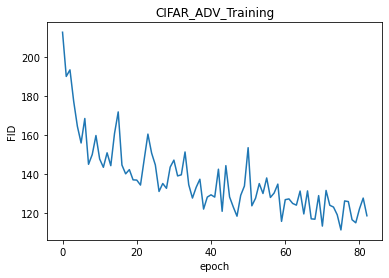

In [17]:
import matplotlib.pyplot as plt

adv_fids = np.array(fid['cifar_adv_ckpt1'])
x = np.arange(len(adv_fids))
plt.plot(x, adv_fids)
plt.xlabel('epoch')
plt.ylabel('FID')
plt.title('CIFAR_ADV_Training')

Text(0.5, 1.0, 'CIFAR_Hybrid_Training')

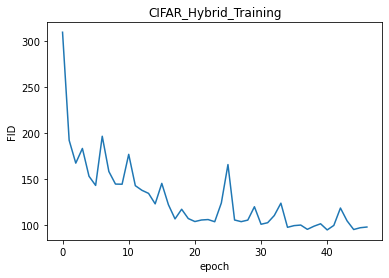

In [14]:
import matplotlib.pyplot as plt

adv_fids = np.array(fid['cifar_hybrid_ckpt1'])
x = np.arange(len(adv_fids))
plt.plot(x, adv_fids)
plt.xlabel('epoch')
plt.ylabel('FID')
plt.title('CIFAR_Hybrid_Training')

Text(0.5, 1.0, 'CIFAR_MLE_Training')

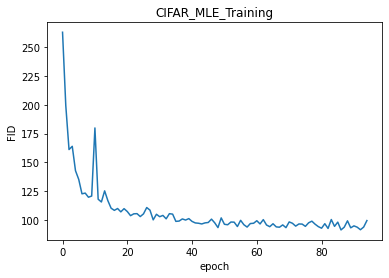

In [15]:
import matplotlib.pyplot as plt

adv_fids = np.array(fid['cifar_mle_ckpt1'])
x = np.arange(len(adv_fids))
plt.plot(x, adv_fids)
plt.xlabel('epoch')
plt.ylabel('FID')
plt.title('CIFAR_MLE_Training')

# CIFAR

In [3]:
import pickle
folders = ['cifar_hybrid_ckpt']
folders1 = ['cifar_hybrid_ckpt1']
epochs = [77]
d = {}
t=0
m1=0
s1=0
for i,folder in enumerate(folders):
    folder1= folders1[i]
    d[folder1]=[]
    for index in range(45,epochs[i]+1):
        !python main.py --dataset 'cifar10' --img_size 32 --no_of_layers 8 --batch_size 32 --netG './$folder/netG_epoch_{index}.pth' --generate 1 --generate_sample_dir $folder1 --generate_num_imgs 1000
        fid,m1,s1 = main(['/nfs/students/winter-term-2020/project-5/cifar_train/',f"./Generated_Images/{folder1}"], t,m1,s1)
        d[folder1].append(fid)
        !rm -rf ./Generated_Images/$folder1
        if t%10==0:
            print(d)
            pickle.dump(d, open('new.pkl', 'wb'))
        t=t+1
    pickle.dump(d, open('new.pkl', 'wb'))

Namespace(alpha=1e-07, batch_size=32, beta1=0.5, beta2=0.999, checkpoint_dir='./flow_gan', dataset='cifar10', df_dim=64, epoch=25, generate=1, generate_num_imgs=1000, generate_sample_dir='cifar_hybrid_ckpt1', hidden_layers=1000, img_size=32, lambda_gp=10.0, like_reg=10.0, log_path='./flow_gan.log', lr=0.0002, lr_decay=0.99999, min_lr=0.0, mode='hybrid', model_type='real_nvp', n_critics=5, netD='', netG='./cifar_hybrid_ckpt/netG_epoch_45.pth', no_of_layers=8, root_dir='./data', sample_dir='./flow_gan_sample', start_epoch=0, writer_log='runs')
31
100%|███████████████████████████████████████████| 31/31 [00:28<00:00,  1.09it/s]
10537.486296622983
16


  0%|          | 0/3125 [00:00<?, ?it/s]

batch_size 16
batch_size1 16


  0%|          | 0/62 [00:00<?, ?it/s]

batch_size 16
batch_size1 16


100%|██████████| 62/62 [00:08<00:00,  7.01it/s]


FID:  100.10954174526432
{'cifar_hybrid_ckpt1': [100.10954174526432]}
Namespace(alpha=1e-07, batch_size=32, beta1=0.5, beta2=0.999, checkpoint_dir='./flow_gan', dataset='cifar10', df_dim=64, epoch=25, generate=1, generate_num_imgs=1000, generate_sample_dir='cifar_hybrid_ckpt1', hidden_layers=1000, img_size=32, lambda_gp=10.0, like_reg=10.0, log_path='./flow_gan.log', lr=0.0002, lr_decay=0.99999, min_lr=0.0, mode='hybrid', model_type='real_nvp', n_critics=5, netD='', netG='./cifar_hybrid_ckpt/netG_epoch_46.pth', no_of_layers=8, root_dir='./data', sample_dir='./flow_gan_sample', start_epoch=0, writer_log='runs')
31
100%|███████████████████████████████████████████| 31/31 [00:29<00:00,  1.05it/s]
13358.913936491936
16


  0%|          | 0/62 [00:00<?, ?it/s]

batch_size 16
batch_size1 16


100%|██████████| 62/62 [00:03<00:00, 15.87it/s]


FID:  97.29661131745684
Namespace(alpha=1e-07, batch_size=32, beta1=0.5, beta2=0.999, checkpoint_dir='./flow_gan', dataset='cifar10', df_dim=64, epoch=25, generate=1, generate_num_imgs=1000, generate_sample_dir='cifar_hybrid_ckpt1', hidden_layers=1000, img_size=32, lambda_gp=10.0, like_reg=10.0, log_path='./flow_gan.log', lr=0.0002, lr_decay=0.99999, min_lr=0.0, mode='hybrid', model_type='real_nvp', n_critics=5, netD='', netG='./cifar_hybrid_ckpt/netG_epoch_47.pth', no_of_layers=8, root_dir='./data', sample_dir='./flow_gan_sample', start_epoch=0, writer_log='runs')
31
100%|███████████████████████████████████████████| 31/31 [00:27<00:00,  1.13it/s]
10891.396011844758
16


  0%|          | 0/62 [00:00<?, ?it/s]

batch_size 16
batch_size1 16


100%|██████████| 62/62 [00:03<00:00, 15.87it/s]


FID:  100.42545782065463
Namespace(alpha=1e-07, batch_size=32, beta1=0.5, beta2=0.999, checkpoint_dir='./flow_gan', dataset='cifar10', df_dim=64, epoch=25, generate=1, generate_num_imgs=1000, generate_sample_dir='cifar_hybrid_ckpt1', hidden_layers=1000, img_size=32, lambda_gp=10.0, like_reg=10.0, log_path='./flow_gan.log', lr=0.0002, lr_decay=0.99999, min_lr=0.0, mode='hybrid', model_type='real_nvp', n_critics=5, netD='', netG='./cifar_hybrid_ckpt/netG_epoch_48.pth', no_of_layers=8, root_dir='./data', sample_dir='./flow_gan_sample', start_epoch=0, writer_log='runs')
31
100%|███████████████████████████████████████████| 31/31 [00:27<00:00,  1.14it/s]
10266.932365171371
16


  0%|          | 0/62 [00:00<?, ?it/s]

batch_size 16
batch_size1 16


100%|██████████| 62/62 [00:04<00:00, 15.45it/s]


FID:  93.69058460463913
Namespace(alpha=1e-07, batch_size=32, beta1=0.5, beta2=0.999, checkpoint_dir='./flow_gan', dataset='cifar10', df_dim=64, epoch=25, generate=1, generate_num_imgs=1000, generate_sample_dir='cifar_hybrid_ckpt1', hidden_layers=1000, img_size=32, lambda_gp=10.0, like_reg=10.0, log_path='./flow_gan.log', lr=0.0002, lr_decay=0.99999, min_lr=0.0, mode='hybrid', model_type='real_nvp', n_critics=5, netD='', netG='./cifar_hybrid_ckpt/netG_epoch_49.pth', no_of_layers=8, root_dir='./data', sample_dir='./flow_gan_sample', start_epoch=0, writer_log='runs')
31
100%|███████████████████████████████████████████| 31/31 [00:27<00:00,  1.13it/s]
11428.47908266129
16


  0%|          | 0/62 [00:00<?, ?it/s]

batch_size 16
batch_size1 16


100%|██████████| 62/62 [00:04<00:00, 15.33it/s]


FID:  98.64710168719921
Namespace(alpha=1e-07, batch_size=32, beta1=0.5, beta2=0.999, checkpoint_dir='./flow_gan', dataset='cifar10', df_dim=64, epoch=25, generate=1, generate_num_imgs=1000, generate_sample_dir='cifar_hybrid_ckpt1', hidden_layers=1000, img_size=32, lambda_gp=10.0, like_reg=10.0, log_path='./flow_gan.log', lr=0.0002, lr_decay=0.99999, min_lr=0.0, mode='hybrid', model_type='real_nvp', n_critics=5, netD='', netG='./cifar_hybrid_ckpt/netG_epoch_50.pth', no_of_layers=8, root_dir='./data', sample_dir='./flow_gan_sample', start_epoch=0, writer_log='runs')
31
100%|███████████████████████████████████████████| 31/31 [00:26<00:00,  1.16it/s]
13409.502236643146
16


  0%|          | 0/62 [00:00<?, ?it/s]

batch_size 16
batch_size1 16


100%|██████████| 62/62 [00:03<00:00, 15.79it/s]


FID:  111.28946835843567
Namespace(alpha=1e-07, batch_size=32, beta1=0.5, beta2=0.999, checkpoint_dir='./flow_gan', dataset='cifar10', df_dim=64, epoch=25, generate=1, generate_num_imgs=1000, generate_sample_dir='cifar_hybrid_ckpt1', hidden_layers=1000, img_size=32, lambda_gp=10.0, like_reg=10.0, log_path='./flow_gan.log', lr=0.0002, lr_decay=0.99999, min_lr=0.0, mode='hybrid', model_type='real_nvp', n_critics=5, netD='', netG='./cifar_hybrid_ckpt/netG_epoch_51.pth', no_of_layers=8, root_dir='./data', sample_dir='./flow_gan_sample', start_epoch=0, writer_log='runs')
31
100%|███████████████████████████████████████████| 31/31 [00:25<00:00,  1.20it/s]
11479.603216355847
16


  0%|          | 0/62 [00:00<?, ?it/s]

batch_size 16
batch_size1 16


100%|██████████| 62/62 [00:03<00:00, 15.70it/s]


FID:  96.43347110958712
Namespace(alpha=1e-07, batch_size=32, beta1=0.5, beta2=0.999, checkpoint_dir='./flow_gan', dataset='cifar10', df_dim=64, epoch=25, generate=1, generate_num_imgs=1000, generate_sample_dir='cifar_hybrid_ckpt1', hidden_layers=1000, img_size=32, lambda_gp=10.0, like_reg=10.0, log_path='./flow_gan.log', lr=0.0002, lr_decay=0.99999, min_lr=0.0, mode='hybrid', model_type='real_nvp', n_critics=5, netD='', netG='./cifar_hybrid_ckpt/netG_epoch_52.pth', no_of_layers=8, root_dir='./data', sample_dir='./flow_gan_sample', start_epoch=0, writer_log='runs')
31
100%|███████████████████████████████████████████| 31/31 [00:27<00:00,  1.12it/s]
11052.074722782258
16


  0%|          | 0/62 [00:00<?, ?it/s]

batch_size 16
batch_size1 16


100%|██████████| 62/62 [00:03<00:00, 15.70it/s]


FID:  97.44873065725943
Namespace(alpha=1e-07, batch_size=32, beta1=0.5, beta2=0.999, checkpoint_dir='./flow_gan', dataset='cifar10', df_dim=64, epoch=25, generate=1, generate_num_imgs=1000, generate_sample_dir='cifar_hybrid_ckpt1', hidden_layers=1000, img_size=32, lambda_gp=10.0, like_reg=10.0, log_path='./flow_gan.log', lr=0.0002, lr_decay=0.99999, min_lr=0.0, mode='hybrid', model_type='real_nvp', n_critics=5, netD='', netG='./cifar_hybrid_ckpt/netG_epoch_53.pth', no_of_layers=8, root_dir='./data', sample_dir='./flow_gan_sample', start_epoch=0, writer_log='runs')
31
100%|███████████████████████████████████████████| 31/31 [00:26<00:00,  1.16it/s]
10016.568138860886
16


  0%|          | 0/62 [00:00<?, ?it/s]

batch_size 16
batch_size1 16


100%|██████████| 62/62 [00:03<00:00, 15.79it/s]


FID:  95.35513892016104
Namespace(alpha=1e-07, batch_size=32, beta1=0.5, beta2=0.999, checkpoint_dir='./flow_gan', dataset='cifar10', df_dim=64, epoch=25, generate=1, generate_num_imgs=1000, generate_sample_dir='cifar_hybrid_ckpt1', hidden_layers=1000, img_size=32, lambda_gp=10.0, like_reg=10.0, log_path='./flow_gan.log', lr=0.0002, lr_decay=0.99999, min_lr=0.0, mode='hybrid', model_type='real_nvp', n_critics=5, netD='', netG='./cifar_hybrid_ckpt/netG_epoch_54.pth', no_of_layers=8, root_dir='./data', sample_dir='./flow_gan_sample', start_epoch=0, writer_log='runs')
31
100%|███████████████████████████████████████████| 31/31 [00:26<00:00,  1.16it/s]
10941.97060861895
16


  0%|          | 0/62 [00:00<?, ?it/s]

batch_size 16
batch_size1 16


100%|██████████| 62/62 [00:03<00:00, 15.66it/s]


FID:  95.24427611007928
Namespace(alpha=1e-07, batch_size=32, beta1=0.5, beta2=0.999, checkpoint_dir='./flow_gan', dataset='cifar10', df_dim=64, epoch=25, generate=1, generate_num_imgs=1000, generate_sample_dir='cifar_hybrid_ckpt1', hidden_layers=1000, img_size=32, lambda_gp=10.0, like_reg=10.0, log_path='./flow_gan.log', lr=0.0002, lr_decay=0.99999, min_lr=0.0, mode='hybrid', model_type='real_nvp', n_critics=5, netD='', netG='./cifar_hybrid_ckpt/netG_epoch_55.pth', no_of_layers=8, root_dir='./data', sample_dir='./flow_gan_sample', start_epoch=0, writer_log='runs')
31
100%|███████████████████████████████████████████| 31/31 [00:26<00:00,  1.15it/s]
9747.240045362903
16


  0%|          | 0/62 [00:00<?, ?it/s]

batch_size 16
batch_size1 16


100%|██████████| 62/62 [00:03<00:00, 15.70it/s]


FID:  93.91493527164658
{'cifar_hybrid_ckpt1': [100.10954174526432, 97.29661131745684, 100.42545782065463, 93.69058460463913, 98.64710168719921, 111.28946835843567, 96.43347110958712, 97.44873065725943, 95.35513892016104, 95.24427611007928, 93.91493527164658]}
Namespace(alpha=1e-07, batch_size=32, beta1=0.5, beta2=0.999, checkpoint_dir='./flow_gan', dataset='cifar10', df_dim=64, epoch=25, generate=1, generate_num_imgs=1000, generate_sample_dir='cifar_hybrid_ckpt1', hidden_layers=1000, img_size=32, lambda_gp=10.0, like_reg=10.0, log_path='./flow_gan.log', lr=0.0002, lr_decay=0.99999, min_lr=0.0, mode='hybrid', model_type='real_nvp', n_critics=5, netD='', netG='./cifar_hybrid_ckpt/netG_epoch_56.pth', no_of_layers=8, root_dir='./data', sample_dir='./flow_gan_sample', start_epoch=0, writer_log='runs')
31
100%|███████████████████████████████████████████| 31/31 [00:26<00:00,  1.17it/s]
9824.463032384072
16


  0%|          | 0/62 [00:00<?, ?it/s]

batch_size 16
batch_size1 16


100%|██████████| 62/62 [00:03<00:00, 15.76it/s]


FID:  95.38692353987574
Namespace(alpha=1e-07, batch_size=32, beta1=0.5, beta2=0.999, checkpoint_dir='./flow_gan', dataset='cifar10', df_dim=64, epoch=25, generate=1, generate_num_imgs=1000, generate_sample_dir='cifar_hybrid_ckpt1', hidden_layers=1000, img_size=32, lambda_gp=10.0, like_reg=10.0, log_path='./flow_gan.log', lr=0.0002, lr_decay=0.99999, min_lr=0.0, mode='hybrid', model_type='real_nvp', n_critics=5, netD='', netG='./cifar_hybrid_ckpt/netG_epoch_57.pth', no_of_layers=8, root_dir='./data', sample_dir='./flow_gan_sample', start_epoch=0, writer_log='runs')
31
100%|███████████████████████████████████████████| 31/31 [00:26<00:00,  1.17it/s]
11829.058877268146
16


  0%|          | 0/62 [00:00<?, ?it/s]

batch_size 16
batch_size1 16


100%|██████████| 62/62 [00:03<00:00, 15.76it/s]


FID:  91.72547464575877
Namespace(alpha=1e-07, batch_size=32, beta1=0.5, beta2=0.999, checkpoint_dir='./flow_gan', dataset='cifar10', df_dim=64, epoch=25, generate=1, generate_num_imgs=1000, generate_sample_dir='cifar_hybrid_ckpt1', hidden_layers=1000, img_size=32, lambda_gp=10.0, like_reg=10.0, log_path='./flow_gan.log', lr=0.0002, lr_decay=0.99999, min_lr=0.0, mode='hybrid', model_type='real_nvp', n_critics=5, netD='', netG='./cifar_hybrid_ckpt/netG_epoch_58.pth', no_of_layers=8, root_dir='./data', sample_dir='./flow_gan_sample', start_epoch=0, writer_log='runs')
31
100%|███████████████████████████████████████████| 31/31 [00:26<00:00,  1.17it/s]
11587.907730594758
16


  0%|          | 0/62 [00:00<?, ?it/s]

batch_size 16
batch_size1 16


100%|██████████| 62/62 [00:03<00:00, 15.64it/s]


FID:  94.81917253935609
Namespace(alpha=1e-07, batch_size=32, beta1=0.5, beta2=0.999, checkpoint_dir='./flow_gan', dataset='cifar10', df_dim=64, epoch=25, generate=1, generate_num_imgs=1000, generate_sample_dir='cifar_hybrid_ckpt1', hidden_layers=1000, img_size=32, lambda_gp=10.0, like_reg=10.0, log_path='./flow_gan.log', lr=0.0002, lr_decay=0.99999, min_lr=0.0, mode='hybrid', model_type='real_nvp', n_critics=5, netD='', netG='./cifar_hybrid_ckpt/netG_epoch_59.pth', no_of_layers=8, root_dir='./data', sample_dir='./flow_gan_sample', start_epoch=0, writer_log='runs')
31
100%|███████████████████████████████████████████| 31/31 [00:25<00:00,  1.20it/s]
10274.653036794354
16


  0%|          | 0/62 [00:00<?, ?it/s]

batch_size 16
batch_size1 16


100%|██████████| 62/62 [00:03<00:00, 15.79it/s]


FID:  91.15258406904633
Namespace(alpha=1e-07, batch_size=32, beta1=0.5, beta2=0.999, checkpoint_dir='./flow_gan', dataset='cifar10', df_dim=64, epoch=25, generate=1, generate_num_imgs=1000, generate_sample_dir='cifar_hybrid_ckpt1', hidden_layers=1000, img_size=32, lambda_gp=10.0, like_reg=10.0, log_path='./flow_gan.log', lr=0.0002, lr_decay=0.99999, min_lr=0.0, mode='hybrid', model_type='real_nvp', n_critics=5, netD='', netG='./cifar_hybrid_ckpt/netG_epoch_60.pth', no_of_layers=8, root_dir='./data', sample_dir='./flow_gan_sample', start_epoch=0, writer_log='runs')
31
100%|███████████████████████████████████████████| 31/31 [00:27<00:00,  1.12it/s]
11153.236611643146
16


  0%|          | 0/62 [00:00<?, ?it/s]

batch_size 16
batch_size1 16


100%|██████████| 62/62 [00:03<00:00, 15.67it/s]


FID:  96.6364738708208
Namespace(alpha=1e-07, batch_size=32, beta1=0.5, beta2=0.999, checkpoint_dir='./flow_gan', dataset='cifar10', df_dim=64, epoch=25, generate=1, generate_num_imgs=1000, generate_sample_dir='cifar_hybrid_ckpt1', hidden_layers=1000, img_size=32, lambda_gp=10.0, like_reg=10.0, log_path='./flow_gan.log', lr=0.0002, lr_decay=0.99999, min_lr=0.0, mode='hybrid', model_type='real_nvp', n_critics=5, netD='', netG='./cifar_hybrid_ckpt/netG_epoch_61.pth', no_of_layers=8, root_dir='./data', sample_dir='./flow_gan_sample', start_epoch=0, writer_log='runs')
31
100%|███████████████████████████████████████████| 31/31 [00:27<00:00,  1.13it/s]
12174.641885080646
16


  0%|          | 0/62 [00:00<?, ?it/s]

batch_size 16
batch_size1 16


100%|██████████| 62/62 [00:03<00:00, 15.73it/s]


FID:  93.3391361724128
Namespace(alpha=1e-07, batch_size=32, beta1=0.5, beta2=0.999, checkpoint_dir='./flow_gan', dataset='cifar10', df_dim=64, epoch=25, generate=1, generate_num_imgs=1000, generate_sample_dir='cifar_hybrid_ckpt1', hidden_layers=1000, img_size=32, lambda_gp=10.0, like_reg=10.0, log_path='./flow_gan.log', lr=0.0002, lr_decay=0.99999, min_lr=0.0, mode='hybrid', model_type='real_nvp', n_critics=5, netD='', netG='./cifar_hybrid_ckpt/netG_epoch_62.pth', no_of_layers=8, root_dir='./data', sample_dir='./flow_gan_sample', start_epoch=0, writer_log='runs')
31
100%|███████████████████████████████████████████| 31/31 [00:26<00:00,  1.19it/s]
12652.100396925403
16


  0%|          | 0/62 [00:00<?, ?it/s]

batch_size 16
batch_size1 16


100%|██████████| 62/62 [00:03<00:00, 15.77it/s]


FID:  92.44422660889745
Namespace(alpha=1e-07, batch_size=32, beta1=0.5, beta2=0.999, checkpoint_dir='./flow_gan', dataset='cifar10', df_dim=64, epoch=25, generate=1, generate_num_imgs=1000, generate_sample_dir='cifar_hybrid_ckpt1', hidden_layers=1000, img_size=32, lambda_gp=10.0, like_reg=10.0, log_path='./flow_gan.log', lr=0.0002, lr_decay=0.99999, min_lr=0.0, mode='hybrid', model_type='real_nvp', n_critics=5, netD='', netG='./cifar_hybrid_ckpt/netG_epoch_63.pth', no_of_layers=8, root_dir='./data', sample_dir='./flow_gan_sample', start_epoch=0, writer_log='runs')
31
100%|███████████████████████████████████████████| 31/31 [00:26<00:00,  1.17it/s]
13962.529485887097
16


  0%|          | 0/62 [00:00<?, ?it/s]

batch_size 16
batch_size1 16


100%|██████████| 62/62 [00:03<00:00, 15.75it/s]


FID:  92.25434465679223
Namespace(alpha=1e-07, batch_size=32, beta1=0.5, beta2=0.999, checkpoint_dir='./flow_gan', dataset='cifar10', df_dim=64, epoch=25, generate=1, generate_num_imgs=1000, generate_sample_dir='cifar_hybrid_ckpt1', hidden_layers=1000, img_size=32, lambda_gp=10.0, like_reg=10.0, log_path='./flow_gan.log', lr=0.0002, lr_decay=0.99999, min_lr=0.0, mode='hybrid', model_type='real_nvp', n_critics=5, netD='', netG='./cifar_hybrid_ckpt/netG_epoch_64.pth', no_of_layers=8, root_dir='./data', sample_dir='./flow_gan_sample', start_epoch=0, writer_log='runs')
31
100%|███████████████████████████████████████████| 31/31 [00:27<00:00,  1.12it/s]
22437.7019594254
16


  0%|          | 0/62 [00:00<?, ?it/s]

batch_size 16
batch_size1 16


100%|██████████| 62/62 [00:03<00:00, 15.79it/s]


FID:  146.52164072144978
Namespace(alpha=1e-07, batch_size=32, beta1=0.5, beta2=0.999, checkpoint_dir='./flow_gan', dataset='cifar10', df_dim=64, epoch=25, generate=1, generate_num_imgs=1000, generate_sample_dir='cifar_hybrid_ckpt1', hidden_layers=1000, img_size=32, lambda_gp=10.0, like_reg=10.0, log_path='./flow_gan.log', lr=0.0002, lr_decay=0.99999, min_lr=0.0, mode='hybrid', model_type='real_nvp', n_critics=5, netD='', netG='./cifar_hybrid_ckpt/netG_epoch_65.pth', no_of_layers=8, root_dir='./data', sample_dir='./flow_gan_sample', start_epoch=0, writer_log='runs')
31
100%|███████████████████████████████████████████| 31/31 [00:26<00:00,  1.15it/s]
16996.784778225807
16


  0%|          | 0/62 [00:00<?, ?it/s]

batch_size 16
batch_size1 16


100%|██████████| 62/62 [00:03<00:00, 15.62it/s]


FID:  118.17218272940175
{'cifar_hybrid_ckpt1': [100.10954174526432, 97.29661131745684, 100.42545782065463, 93.69058460463913, 98.64710168719921, 111.28946835843567, 96.43347110958712, 97.44873065725943, 95.35513892016104, 95.24427611007928, 93.91493527164658, 95.38692353987574, 91.72547464575877, 94.81917253935609, 91.15258406904633, 96.6364738708208, 93.3391361724128, 92.44422660889745, 92.25434465679223, 146.52164072144978, 118.17218272940175]}
Namespace(alpha=1e-07, batch_size=32, beta1=0.5, beta2=0.999, checkpoint_dir='./flow_gan', dataset='cifar10', df_dim=64, epoch=25, generate=1, generate_num_imgs=1000, generate_sample_dir='cifar_hybrid_ckpt1', hidden_layers=1000, img_size=32, lambda_gp=10.0, like_reg=10.0, log_path='./flow_gan.log', lr=0.0002, lr_decay=0.99999, min_lr=0.0, mode='hybrid', model_type='real_nvp', n_critics=5, netD='', netG='./cifar_hybrid_ckpt/netG_epoch_66.pth', no_of_layers=8, root_dir='./data', sample_dir='./flow_gan_sample', start_epoch=0, writer_log='runs')


  0%|          | 0/62 [00:00<?, ?it/s]

batch_size 16
batch_size1 16


100%|██████████| 62/62 [00:03<00:00, 15.75it/s]


FID:  102.1671696955325
Namespace(alpha=1e-07, batch_size=32, beta1=0.5, beta2=0.999, checkpoint_dir='./flow_gan', dataset='cifar10', df_dim=64, epoch=25, generate=1, generate_num_imgs=1000, generate_sample_dir='cifar_hybrid_ckpt1', hidden_layers=1000, img_size=32, lambda_gp=10.0, like_reg=10.0, log_path='./flow_gan.log', lr=0.0002, lr_decay=0.99999, min_lr=0.0, mode='hybrid', model_type='real_nvp', n_critics=5, netD='', netG='./cifar_hybrid_ckpt/netG_epoch_67.pth', no_of_layers=8, root_dir='./data', sample_dir='./flow_gan_sample', start_epoch=0, writer_log='runs')
31
100%|███████████████████████████████████████████| 31/31 [00:26<00:00,  1.18it/s]
12301.019862021169
16


  0%|          | 0/62 [00:00<?, ?it/s]

batch_size 16
batch_size1 16


100%|██████████| 62/62 [00:03<00:00, 15.67it/s]


FID:  92.41370044644486
Namespace(alpha=1e-07, batch_size=32, beta1=0.5, beta2=0.999, checkpoint_dir='./flow_gan', dataset='cifar10', df_dim=64, epoch=25, generate=1, generate_num_imgs=1000, generate_sample_dir='cifar_hybrid_ckpt1', hidden_layers=1000, img_size=32, lambda_gp=10.0, like_reg=10.0, log_path='./flow_gan.log', lr=0.0002, lr_decay=0.99999, min_lr=0.0, mode='hybrid', model_type='real_nvp', n_critics=5, netD='', netG='./cifar_hybrid_ckpt/netG_epoch_68.pth', no_of_layers=8, root_dir='./data', sample_dir='./flow_gan_sample', start_epoch=0, writer_log='runs')
31
100%|███████████████████████████████████████████| 31/31 [00:27<00:00,  1.15it/s]
10928.604366179436
16


  0%|          | 0/62 [00:00<?, ?it/s]

batch_size 16
batch_size1 16


100%|██████████| 62/62 [00:03<00:00, 15.66it/s]


FID:  92.2722235155291
Namespace(alpha=1e-07, batch_size=32, beta1=0.5, beta2=0.999, checkpoint_dir='./flow_gan', dataset='cifar10', df_dim=64, epoch=25, generate=1, generate_num_imgs=1000, generate_sample_dir='cifar_hybrid_ckpt1', hidden_layers=1000, img_size=32, lambda_gp=10.0, like_reg=10.0, log_path='./flow_gan.log', lr=0.0002, lr_decay=0.99999, min_lr=0.0, mode='hybrid', model_type='real_nvp', n_critics=5, netD='', netG='./cifar_hybrid_ckpt/netG_epoch_69.pth', no_of_layers=8, root_dir='./data', sample_dir='./flow_gan_sample', start_epoch=0, writer_log='runs')
31
100%|███████████████████████████████████████████| 31/31 [00:26<00:00,  1.16it/s]
10731.756016885081
16


  0%|          | 0/62 [00:00<?, ?it/s]

batch_size 16
batch_size1 16


100%|██████████| 62/62 [00:03<00:00, 15.78it/s]


FID:  92.74752570783892
Namespace(alpha=1e-07, batch_size=32, beta1=0.5, beta2=0.999, checkpoint_dir='./flow_gan', dataset='cifar10', df_dim=64, epoch=25, generate=1, generate_num_imgs=1000, generate_sample_dir='cifar_hybrid_ckpt1', hidden_layers=1000, img_size=32, lambda_gp=10.0, like_reg=10.0, log_path='./flow_gan.log', lr=0.0002, lr_decay=0.99999, min_lr=0.0, mode='hybrid', model_type='real_nvp', n_critics=5, netD='', netG='./cifar_hybrid_ckpt/netG_epoch_70.pth', no_of_layers=8, root_dir='./data', sample_dir='./flow_gan_sample', start_epoch=0, writer_log='runs')
31
100%|███████████████████████████████████████████| 31/31 [00:26<00:00,  1.16it/s]
9478.360666582661
16


  0%|          | 0/62 [00:00<?, ?it/s]

batch_size 16
batch_size1 16


100%|██████████| 62/62 [00:03<00:00, 15.67it/s]


FID:  94.10293754887175
Namespace(alpha=1e-07, batch_size=32, beta1=0.5, beta2=0.999, checkpoint_dir='./flow_gan', dataset='cifar10', df_dim=64, epoch=25, generate=1, generate_num_imgs=1000, generate_sample_dir='cifar_hybrid_ckpt1', hidden_layers=1000, img_size=32, lambda_gp=10.0, like_reg=10.0, log_path='./flow_gan.log', lr=0.0002, lr_decay=0.99999, min_lr=0.0, mode='hybrid', model_type='real_nvp', n_critics=5, netD='', netG='./cifar_hybrid_ckpt/netG_epoch_71.pth', no_of_layers=8, root_dir='./data', sample_dir='./flow_gan_sample', start_epoch=0, writer_log='runs')
31
100%|███████████████████████████████████████████| 31/31 [00:27<00:00,  1.15it/s]
12448.8666047127
16


  0%|          | 0/62 [00:00<?, ?it/s]

batch_size 16
batch_size1 16


100%|██████████| 62/62 [00:03<00:00, 15.75it/s]


FID:  95.47810606327408
Namespace(alpha=1e-07, batch_size=32, beta1=0.5, beta2=0.999, checkpoint_dir='./flow_gan', dataset='cifar10', df_dim=64, epoch=25, generate=1, generate_num_imgs=1000, generate_sample_dir='cifar_hybrid_ckpt1', hidden_layers=1000, img_size=32, lambda_gp=10.0, like_reg=10.0, log_path='./flow_gan.log', lr=0.0002, lr_decay=0.99999, min_lr=0.0, mode='hybrid', model_type='real_nvp', n_critics=5, netD='', netG='./cifar_hybrid_ckpt/netG_epoch_72.pth', no_of_layers=8, root_dir='./data', sample_dir='./flow_gan_sample', start_epoch=0, writer_log='runs')
31
100%|███████████████████████████████████████████| 31/31 [00:26<00:00,  1.16it/s]
14405.31306703629
16


  0%|          | 0/62 [00:00<?, ?it/s]

batch_size 16
batch_size1 16


100%|██████████| 62/62 [00:03<00:00, 15.71it/s]


FID:  94.20266141526957
Namespace(alpha=1e-07, batch_size=32, beta1=0.5, beta2=0.999, checkpoint_dir='./flow_gan', dataset='cifar10', df_dim=64, epoch=25, generate=1, generate_num_imgs=1000, generate_sample_dir='cifar_hybrid_ckpt1', hidden_layers=1000, img_size=32, lambda_gp=10.0, like_reg=10.0, log_path='./flow_gan.log', lr=0.0002, lr_decay=0.99999, min_lr=0.0, mode='hybrid', model_type='real_nvp', n_critics=5, netD='', netG='./cifar_hybrid_ckpt/netG_epoch_73.pth', no_of_layers=8, root_dir='./data', sample_dir='./flow_gan_sample', start_epoch=0, writer_log='runs')
31
100%|███████████████████████████████████████████| 31/31 [00:27<00:00,  1.13it/s]
11770.561287172379
16


  0%|          | 0/62 [00:00<?, ?it/s]

batch_size 16
batch_size1 16


100%|██████████| 62/62 [00:03<00:00, 15.68it/s]


FID:  92.58392238840077
Namespace(alpha=1e-07, batch_size=32, beta1=0.5, beta2=0.999, checkpoint_dir='./flow_gan', dataset='cifar10', df_dim=64, epoch=25, generate=1, generate_num_imgs=1000, generate_sample_dir='cifar_hybrid_ckpt1', hidden_layers=1000, img_size=32, lambda_gp=10.0, like_reg=10.0, log_path='./flow_gan.log', lr=0.0002, lr_decay=0.99999, min_lr=0.0, mode='hybrid', model_type='real_nvp', n_critics=5, netD='', netG='./cifar_hybrid_ckpt/netG_epoch_74.pth', no_of_layers=8, root_dir='./data', sample_dir='./flow_gan_sample', start_epoch=0, writer_log='runs')
31
100%|███████████████████████████████████████████| 31/31 [00:26<00:00,  1.17it/s]
11327.610367313508
16


  0%|          | 0/62 [00:00<?, ?it/s]

batch_size 16
batch_size1 16


100%|██████████| 62/62 [00:03<00:00, 15.78it/s]


FID:  91.69206639501095
Namespace(alpha=1e-07, batch_size=32, beta1=0.5, beta2=0.999, checkpoint_dir='./flow_gan', dataset='cifar10', df_dim=64, epoch=25, generate=1, generate_num_imgs=1000, generate_sample_dir='cifar_hybrid_ckpt1', hidden_layers=1000, img_size=32, lambda_gp=10.0, like_reg=10.0, log_path='./flow_gan.log', lr=0.0002, lr_decay=0.99999, min_lr=0.0, mode='hybrid', model_type='real_nvp', n_critics=5, netD='', netG='./cifar_hybrid_ckpt/netG_epoch_75.pth', no_of_layers=8, root_dir='./data', sample_dir='./flow_gan_sample', start_epoch=0, writer_log='runs')
31
100%|███████████████████████████████████████████| 31/31 [00:26<00:00,  1.18it/s]
13875.59724672379
16


  0%|          | 0/62 [00:00<?, ?it/s]

batch_size 16
batch_size1 16


100%|██████████| 62/62 [00:03<00:00, 15.75it/s]


FID:  92.95449799033418
{'cifar_hybrid_ckpt1': [100.10954174526432, 97.29661131745684, 100.42545782065463, 93.69058460463913, 98.64710168719921, 111.28946835843567, 96.43347110958712, 97.44873065725943, 95.35513892016104, 95.24427611007928, 93.91493527164658, 95.38692353987574, 91.72547464575877, 94.81917253935609, 91.15258406904633, 96.6364738708208, 93.3391361724128, 92.44422660889745, 92.25434465679223, 146.52164072144978, 118.17218272940175, 102.1671696955325, 92.41370044644486, 92.2722235155291, 92.74752570783892, 94.10293754887175, 95.47810606327408, 94.20266141526957, 92.58392238840077, 91.69206639501095, 92.95449799033418]}
Namespace(alpha=1e-07, batch_size=32, beta1=0.5, beta2=0.999, checkpoint_dir='./flow_gan', dataset='cifar10', df_dim=64, epoch=25, generate=1, generate_num_imgs=1000, generate_sample_dir='cifar_hybrid_ckpt1', hidden_layers=1000, img_size=32, lambda_gp=10.0, like_reg=10.0, log_path='./flow_gan.log', lr=0.0002, lr_decay=0.99999, min_lr=0.0, mode='hybrid', mode

  0%|          | 0/62 [00:00<?, ?it/s]

batch_size 16
batch_size1 16


100%|██████████| 62/62 [00:05<00:00, 11.44it/s]


FID:  93.35812036210814
Namespace(alpha=1e-07, batch_size=32, beta1=0.5, beta2=0.999, checkpoint_dir='./flow_gan', dataset='cifar10', df_dim=64, epoch=25, generate=1, generate_num_imgs=1000, generate_sample_dir='cifar_hybrid_ckpt1', hidden_layers=1000, img_size=32, lambda_gp=10.0, like_reg=10.0, log_path='./flow_gan.log', lr=0.0002, lr_decay=0.99999, min_lr=0.0, mode='hybrid', model_type='real_nvp', n_critics=5, netD='', netG='./cifar_hybrid_ckpt/netG_epoch_77.pth', no_of_layers=8, root_dir='./data', sample_dir='./flow_gan_sample', start_epoch=0, writer_log='runs')
31
100%|███████████████████████████████████████████| 31/31 [00:26<00:00,  1.15it/s]
10514.55330141129
16


  0%|          | 0/62 [00:00<?, ?it/s]

batch_size 16
batch_size1 16


100%|██████████| 62/62 [00:03<00:00, 15.80it/s]


FID:  92.75652405578006
